# BI_TRIGRAMS — Bigrams & Trigrams for War and Peace and Anna Karenina

This notebook computes and visualizes the top bigrams and trigrams for *War and Peace* and *Anna Karenina*.
It follows the project structure: auto-detects `data/` and `results/`, saves outputs to `results/bi_trigrams/`.

Run cells top-to-bottom. If you are missing packages, run the optional pip install cell.


In [1]:
# If packages are missing in this kernel, uncomment and run the following (uses the kernel's Python):
# import sys
# !{sys.executable} -m pip install pandas nltk matplotlib tqdm
print('If needed: uncomment the pip install lines above and run this cell.')


If needed: uncomment the pip install lines above and run this cell.


In [2]:
import re
from pathlib import Path
from collections import Counter
import json
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
try:
    import pandas as pd
except Exception:
    pd = None

import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

print('Imports set up. pandas present=' + str(pd is not None))


Imports set up. pandas present=False


In [ ]:
# Auto-detect data and results directories (work whether notebook is in notebooks/ or project root)
BASE_DIR = Path().resolve()
if (BASE_DIR / 'data').exists():
    DATA_DIR = BASE_DIR / 'data'
    RESULTS_DIR = BASE_DIR / 'results'
elif (BASE_DIR.parent / 'data').exists():
    DATA_DIR = BASE_DIR.parent / 'data'
    RESULTS_DIR = BASE_DIR.parent / 'results'
else:
    raise FileNotFoundError('Could not locate data/ directory. Make sure your project layout is correct.')

OUT_DIR = RESULTS_DIR / 'bi_trigrams'
OUT_DIR.mkdir(parents=True, exist_ok=True)
print('DATA_DIR =', DATA_DIR)
print('OUT_DIR =', OUT_DIR)

def find_book_file(data_dir, keywords):
    for p in data_dir.iterdir():
        if p.is_file():
            name = p.name.lower()
            if all(k.lower() in name for k in keywords):
                return p
    return None

war_file = find_book_file(DATA_DIR, ['war', 'peace'])
anna_file = find_book_file(DATA_DIR, ['anna', 'karen'])
if war_file is None or anna_file is None:
    print('Files in data/:')
    for p in DATA_DIR.iterdir():
        print(' -', p.name)
    raise FileNotFoundError('Could not find War/Anna files in data directory')
print('War file:', war_file.name)
print('Anna file:', anna_file.name)


DATA_DIR = C:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\data
OUT_DIR = C:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\results\bi_trigrams
War file: The Project Gutenberg eBook of War and Peace, by Leo Tolstoy.txt
Anna file: The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt


In [4]:
def read_text(path: Path) -> str:
    with open(path, 'r', encoding='utf-8', errors='replace') as f:
        return f.read()

def clean_text_gutenberg(s: str) -> str:
    # Remove Gutenberg header/footer blocks
    s = re.sub(r"\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*", '', s, flags=re.IGNORECASE|re.DOTALL)
    s = re.sub(r"\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*", '', s, flags=re.IGNORECASE|re.DOTALL)
    # Remove a leading header block (heuristic until first chapter marker)
    s = re.sub(r'^[\s\S]{0,2000}?(?=(chapter|book|part|i\.|1\.|chapter i))', '', s, flags=re.IGNORECASE)
    # Fix hyphenated line breaks like 'Rost-\nov' or 'Rost-\n ov' -> 'Rostov'
    s = re.sub(r"-\s*\n\s*", '', s)
    # Replace remaining newlines/tabs with spaces
    s = re.sub(r'[\t\r\n]+', ' ', s)
    # Collapse multiple spaces
    s = re.sub(r'\s+', ' ', s)
    return s.strip()

war_raw = read_text(war_file)
anna_raw = read_text(anna_file)
war_text = clean_text_gutenberg(war_raw)
anna_text = clean_text_gutenberg(anna_raw)
print('Clean lengths: War', len(war_text), 'Anna', len(anna_text))


Clean lengths: War 3210563 Anna 1974844


In [5]:
stop_words = set(stopwords.words('english'))

def tokenize_for_ngrams(text: str):
    tokens = word_tokenize(text)
    # Keep alphabetic tokens, remove pure punctuation and numbers
    tokens = [t for t in tokens if any(ch.isalnum() for ch in t)]
    # Normalize to lowercase
    tokens = [t.lower() for t in tokens]
    # Remove tokens that are single letters except 'a' and 'i' (often artifacts after bad splits)
    tokens = [t for t in tokens if not (len(t) == 1 and t not in {'a','i'})]
    # Optionally remove stopwords to focus on content n-grams; keep commented if you prefer function words
    # tokens = [t for t in tokens if t not in stop_words]
    return tokens

war_tokens = tokenize_for_ngrams(war_text)
anna_tokens = tokenize_for_ngrams(anna_text)
print('Sample tokens (war):', war_tokens[:30])


Sample tokens (war): ['book', 'of', 'war', 'and', 'peace', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'in', 'the', 'united', 'states', 'and', 'most', 'other', 'parts', 'of', 'the', 'world', 'at', 'no', 'cost', 'and', 'with']


In [6]:
def top_ngrams(tokens, n=2, top_k=20):
    grams = ngrams(tokens, n)
    counts = Counter(grams)
    return counts.most_common(top_k)

war_bigrams = top_ngrams(war_tokens, n=2, top_k=50)
war_trigrams = top_ngrams(war_tokens, n=3, top_k=50)
anna_bigrams = top_ngrams(anna_tokens, n=2, top_k=50)
anna_trigrams = top_ngrams(anna_tokens, n=3, top_k=50)

def grams_to_df(pairs):
    import pandas as _pd
    rows = [( ' '.join(g), c) for g,c in pairs]
    return _pd.DataFrame(rows, columns=['ngram','count'])

if pd is not None:
    war_bi_df = grams_to_df(war_bigrams[:20])
    war_tri_df = grams_to_df(war_trigrams[:20])
    anna_bi_df = grams_to_df(anna_bigrams[:20])
    anna_tri_df = grams_to_df(anna_trigrams[:20])
    display(war_bi_df)


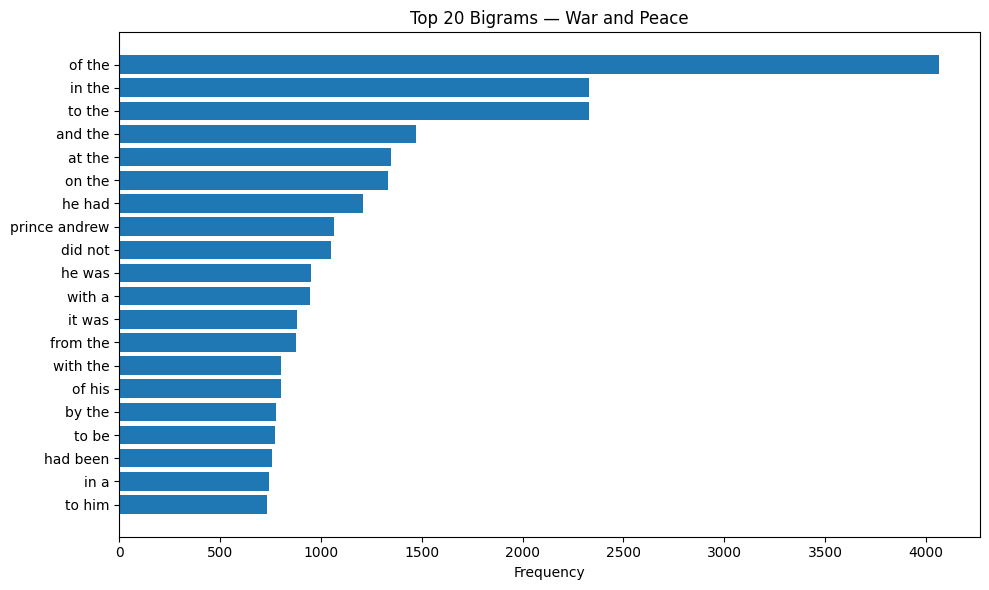

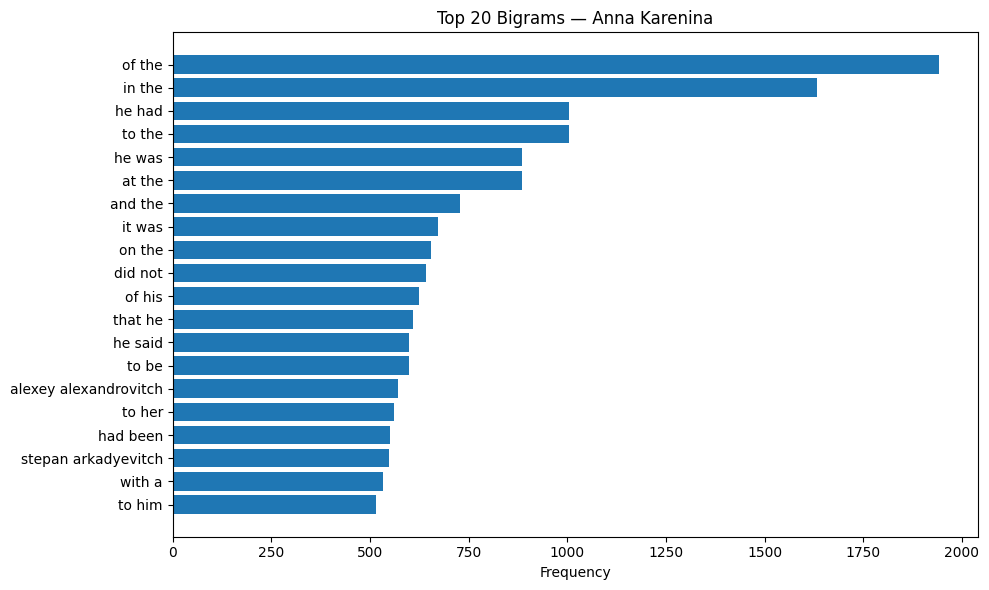

In [7]:
def plot_top_ngrams(pairs, title, outpath):
    labels = [' '.join(g) for g,_ in pairs]
    counts = [c for _,c in pairs]
    y = np.arange(len(labels))
    plt.figure(figsize=(10,6))
    plt.barh(y, counts, color='#1f77b4')
    plt.yticks(y, labels)
    plt.gca().invert_yaxis()
    plt.xlabel('Frequency')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.show()

plot_top_ngrams(war_bigrams[:20], 'Top 20 Bigrams — War and Peace', OUT_DIR / 'war_top20_bigrams.png')
plot_top_ngrams(anna_bigrams[:20], 'Top 20 Bigrams — Anna Karenina', OUT_DIR / 'anna_top20_bigrams.png')


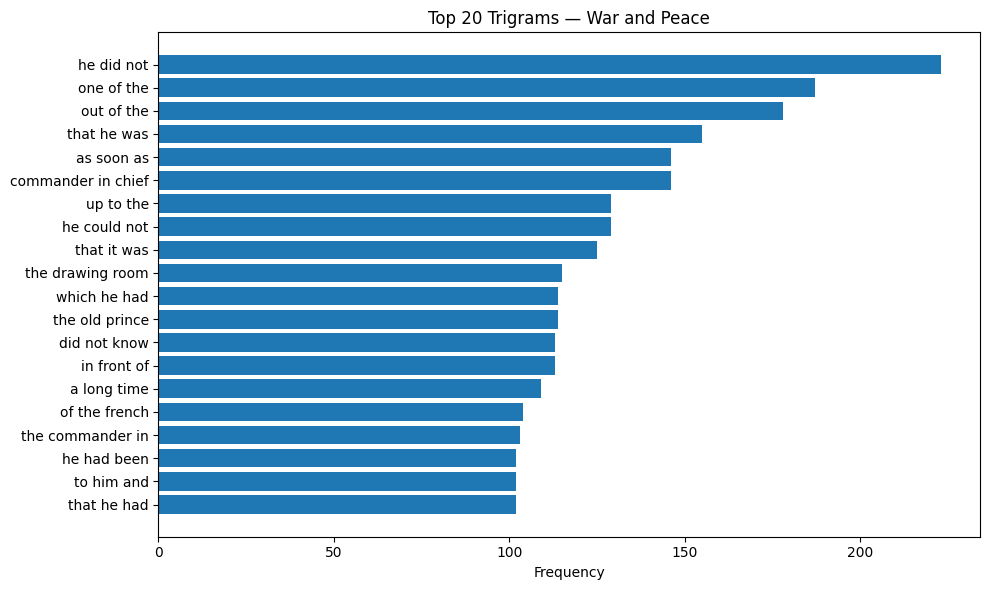

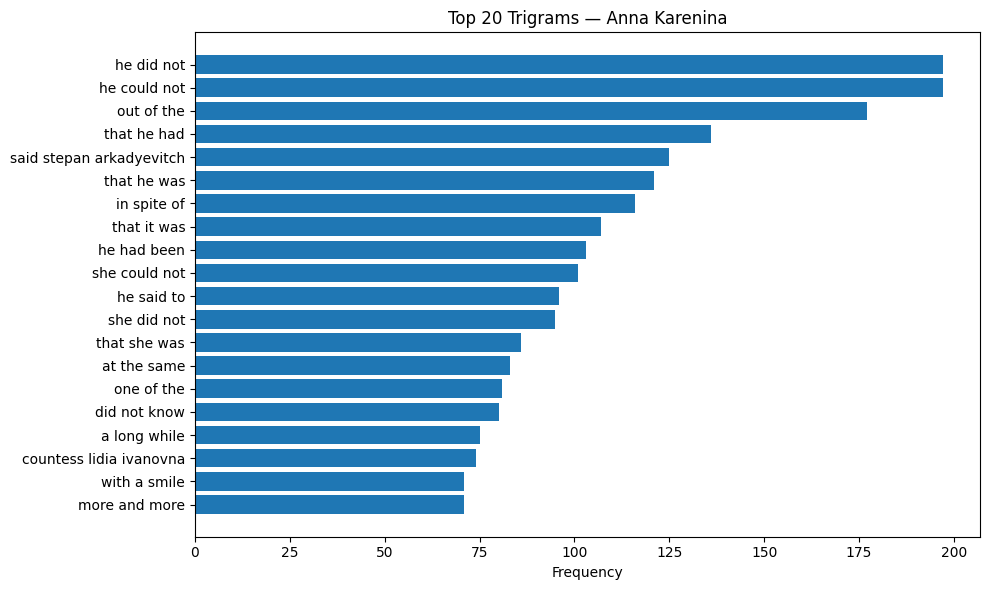

In [8]:
plot_top_ngrams(war_trigrams[:20], 'Top 20 Trigrams — War and Peace', OUT_DIR / 'war_top20_trigrams.png')
plot_top_ngrams(anna_trigrams[:20], 'Top 20 Trigrams — Anna Karenina', OUT_DIR / 'anna_top20_trigrams.png')


In [9]:
def save_ngrams(pairs, path_csv, path_json):
    rows = [{'ngram':' '.join(g), 'count':c} for g,c in pairs]
    if pd is not None:
        pd.DataFrame(rows).to_csv(path_csv, index=False)
    
    with open(path_json, 'w', encoding='utf-8') as f:
        json.dump(rows, f, indent=2)

save_ngrams(war_bigrams[:50], OUT_DIR / 'war_bigrams_top50.csv', OUT_DIR / 'war_bigrams_top50.json')
save_ngrams(anna_bigrams[:50], OUT_DIR / 'anna_bigrams_top50.csv', OUT_DIR / 'anna_bigrams_top50.json')
save_ngrams(war_trigrams[:50], OUT_DIR / 'war_trigrams_top50.csv', OUT_DIR / 'war_trigrams_top50.json')
save_ngrams(anna_trigrams[:50], OUT_DIR / 'anna_trigrams_top50.csv', OUT_DIR / 'anna_trigrams_top50.json')
print('Saved CSV/JSON to', OUT_DIR)


Saved CSV/JSON to C:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\results\bi_trigrams


In [10]:
def find_contexts(text, ngram, window=40, max_examples=5):
    toks = word_tokenize(text)
    toks = [t.lower() for t in toks]
    target = ngram.split()
    k = len(target)
    examples = []
    for i in range(len(toks)-k+1):
        if toks[i:i+k] == target:
            start = max(0, i-window)
            end = min(len(toks), i+k+window)
            examples.append(' '.join(toks[start:end]))
            if len(examples) >= max_examples:
                break
    return examples

# Example: show contexts for the top bigram/trigram
top_war_bigram = ' '.join(war_bigrams[0][0])
print('Top war bigram:', top_war_bigram)
print(find_contexts(war_text, top_war_bigram, window=10, max_examples=3))


Top war bigram: of the
['anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever', ', give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at', 'united states , you will have to check the laws of the country where you are located before using this ebook .']


## Notes
- This notebook fixes earlier tokenization issues by cleaning hyphenated line breaks and removing stray single-letter tokens.
- If you still see odd bigrams (like `rost v`), rerun the cleaning cell and inspect the raw text around the offending token using `find_contexts`.
- The notebook writes figures and CSV/JSON to `results/bi_trigrams/`.
